In [1]:
import numpy
import random
from functools import cmp_to_key
import matplotlib.pyplot as plt


In [2]:
random.seed()


In [3]:
class Sudoku(object):
    """ Uses a Genetic Algorithm to solve Sudoku inputed as a 9x9 matrix in list format. Requires other libary 
    instances and methods, also included in this Notebook.
    
    """

    def __init__(self):
        self.original = None
        return
    
    def load(self, board):
        '''
        Transforms a list of lists into a np array, which represents the Sudoku board, then saves it as class attibute.
        
        Input: List
        Output: None
        '''
        values = numpy.array(board)
        self.original = Original(values)          
        return

        
    def solve(self):
        '''
        Algorithm to solve Sudoku using GAs Selection, Mutation adn Crossover methods. It ouputs the last generation previous to
        the finalization of the generations and a list containing all fitness until then.
        
        Input: None
        Output: Tuple (int, list)
        '''
        history=[] #List to save fitness information of the trials
        candi = 1000  # Number of candidates 
        elit = 5  # Number of elites.
        gen = 1200  # Number of generations.
        mutation_rate = 0.08
        crossover_rate = .8
        
        # Initial Pop is created
        self.population = Population()
        self.population.trial(candi, self.original)
    
        # For up to 10000 generations, whatever if patience reach certain point it will re seed starting from the last generation
        patience = 0
        for generation in range(0, gen):
        
            print("Generation %d" % generation)
            
            # Look for a solution.
            best_fitness = 0.0
            for c in range(0, candi):
                fitness = self.population.candidates[c].fitness
                if(fitness == 1):
                    print("Solution found at generation %d!" % generation)
                    print(self.population.candidates[c].values)
                    return (generation,history )

                # Replace if fitness is better
                if(fitness > best_fitness):
                    best_fitness = fitness

            print("Best fitness: %f" % best_fitness)

            # Create the next population.
            next_population = []

            # Select elites and save them for the future.
            self.population.fitsort()
            elites = []
            for e in range(0, elit):
                elite = Individual()
                elite.values = numpy.copy(self.population.candidates[e].values)
                elites.append(elite)

            # Begin creating new generation
            for nggr in range(elit, candi, 2):
                
                 # Selection methods
                s = Roulette()
                
                parent1 = s.compete(self.population.candidates)
                parent2 = s.compete(self.population.candidates)
                
                ## Cross-over.
                x = Crossover()
                child1, child2 = x.cyclecrossover(parent1, parent2, crossover_rate)
                
                # Mutation
                if child1.fitness is None:
                    old_fitness = 0
                else:
                    old_fitness = child1.fitness
                success = child1.swap_mutate(mutation_rate, self.original)
                child1.update_fitness()


                if child2.fitness is None:
                    old_fitness = 0
                else:
                    old_fitness = child2.fitness
                success = child2.swap_mutate(mutation_rate, self.original)
                child2.update_fitness()

                
                # Add children to new population.
                next_population.append(child1)
                next_population.append(child2)

            # Append the elites into the end of the population
            for e in range(0, elit):
                next_population.append(elites[e])
                
            # Select next generation.
            self.population.candidates = next_population
            self.population.update_fitness()
            

            # Check if we ran out of patience, confirm if fitness is still evolving
            self.population.fitsort()
            if(self.population.candidates[0].fitness != best_fitness):
                patience = 0
            else:
                patience += 1
            history.append(best_fitness)
            
            # Restart  if 250 generations have passed with best fitness not evolving.
            if(patience >= 250):
                print("Population is not yet evolving anymore. Try again")
                self.population.trial(candi, self.original)
                patience = 0
                mutation_rate = 0.06
        
        print("No solution was found")
        return (None,history)

In [4]:
class Individual(object):
    """ 
    This represents a possible member of a population. It has fitness and values attributes as the caracteristics of a solution
    of a Sudoku board.
    
    """
    def __init__(self):
        self.values = numpy.zeros((9, 9), dtype=int) #9x9 zero matrix
        self.fitness = None
        return

    def update_fitness(self):
        '''
        This method updates/assigns a fitness to the Individual based on its closeness to the optimal (only correct) solution.
        Achieved by evaluating the number of diferent number in each of the 9 columns and blocks and then adding up their scores
        
        Input: None
        Output: None
        '''
        
        row_count = numpy.zeros(9)
        column_count = numpy.zeros(9)
        block_count = numpy.zeros(9)
        row_sum = 0
        column_sum = 0
        block_sum = 0

        for i in range(0, 9):  # For each row...
            for j in range(0, 9):  # For each number within it...
                row_count[self.values[i][j]-1] += 1  # ...Update list with occurrence of a particular number.
            row_sum += (1.0/len(set(row_count)))/9 #I think fitness will always be the same for all rows
            row_count = numpy.zeros(9)

        for i in range(0, 9):  # For each column...
            for j in range(0, 9):  # For each number within it...
                column_count[self.values[j][i]-1] += 1  # ...Update list with occurrence of a particular number.
#Here columns can be repeated so as more ocurrences of a same number less fitness?
            column_sum += (1.0 / len(set(column_count)))/9
            column_count = numpy.zeros(9)


        # For each block... wich actually only works for 9x9
        
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                #We could take out this 3 
                block_count[self.values[i][j]-1] += 1
                block_count[self.values[i][j+1]-1] += 1
                block_count[self.values[i][j+2]-1] += 1
                
                block_count[self.values[i+1][j]-1] += 1
                block_count[self.values[i+1][j+1]-1] += 1
                block_count[self.values[i+1][j+2]-1] += 1
                
                block_count[self.values[i+2][j]-1] += 1
                block_count[self.values[i+2][j+1]-1] += 1
                block_count[self.values[i+2][j+2]-1] += 1

                block_sum += (1.0/len(set(block_count)))/9
                block_count = numpy.zeros(9)

        # Calculate overall fitness.
        if (int(row_sum) == 1 and int(column_sum) == 1 and int(block_sum) == 1):
            fitness = 1.0
        else: #Removed row_sum as it didnt changed
            fitness = row_sum * column_sum * block_sum
        
        self.fitness = fitness
        return
        
    def swap_mutate(self, mutation_rate, original):
        """ 
        GA Swap Mutation. A random row is selected to mutate, that row exchange 2 random squares for each other. The method makes
        sure that not an unmutable square is being modified nor any of its rows, columns or blocks are modified. Finally returns
        a Boolean that indicates a succesfull mutation or not.
        
        Input:Float, Individual()
        Output: Boolean
        
        """

        r = random.uniform(0, 1)

        success = False
        if (r <= mutation_rate):  # Mutate.
            while(not success):
                row = random.randint(0, 8)
                   
                columns = random.sample([i for i in range(8)],2)
                from_column = columns[0]
                to_column = columns[1]
                
                
                # Check if the two places are free...
                if(original.values[row][from_column] == 0 and original.values[row][to_column] == 0):
                    # ...and that we are not causing a duplicate in the original blockas & columns.
                    if(not original.is_column_duplicate(to_column, self.values[row][from_column])
                       and not original.is_column_duplicate(from_column, self.values[row][to_column])
                       and not original.is_block_duplicate(row, to_column, self.values[row][from_column])
                       and not original.is_block_duplicate(row, from_column, self.values[row][to_column])):
                    
                        # Swap values.
                        temp = self.values[row][to_column]
                        self.values[row][to_column] = self.values[row][from_column]
                        self.values[row][from_column] = temp
                        success = True
     #We have to do this type of mutation as the duplicates must be managed carefully

        return success  

    def inversion_mutate(self, mutation_rate, original):
        """ 
        GA Inversion Mutation. A random row is selected to mutate, a serial segment within two unmutable squares is inverted, 
        this means its values are exchange the final of the segment for the first and vicerversa, for all the values within the rows.
        
        Input:Float, Individual()
        Output: Boolean
        
        """
        r = random.uniform(0, 1)
        success = False
        if (r <= mutation_rate):
            counter = 0
            while (not success and counter<300):
                
                row = random.randint(0, 8)
                forbiddens = []
                for i,nopes in enumerate(original.values[row]):
                    if nopes != 0:
                        forbiddens.append(i)
                
                forbiddens.append(-1)
                forbiddens.append(9)

                forbiddens = list(set(forbiddens))

                if len(forbiddens) == 2:
                    forbiddens.append(random.randint(0, 8))
                
                col_idx_1 = random.randint(0,len(forbiddens)-2)
                col_1 = forbiddens[col_idx_1] #4
                col_2 = forbiddens[col_idx_1+1] #7

                spaces = col_2 - col_1-1
                                 
                if spaces > 1:
                    #self.values[row][col_1+1 : col_2-1] = self.values[row][col_1+1 : col_2-1][::-1]
                    space_list = []
                    check = 0
                    for space_in in range(1,spaces+1):
                        space_list.append(self.values[row][col_1+space_in])
                    for space_check in range(1,spaces+1):
                        if(not original.is_column_duplicate(col_2-space_check, space_list[space_check-1])
                           and not original.is_block_duplicate(row, col_2-space_check,  space_list[space_check-1])):
                            check += 1
                        else :
                            
                            check = 0
                    if check == spaces:
                        for space_out in range(1,spaces+1):
                            self.values[row][col_2-space_out] = space_list[space_out-1]
                        success = True
                    counter += 1
        return success

In [5]:
class Population(object):
    """ 
    A set of possible solutions to the Sudoku puzzle in the generation.
    """

    def __init__(self):
        self.candidates = []
        return

    def trial(self, candi, matrix):
        self.candidates = []
        
        # Determine the legal values that each square can take.
        guidelines = Individual()
        guidelines.values = [[[] for j in range(0, 9)] for i in range(0, 9)]
        #The matrix became a 9x9 of [] spaces
        for row in range(0, 9):
            for column in range(0, 9):
                for value in range(1, 10):
                    if((matrix.values[row][column] == 0) and not (matrix.is_column_duplicate(column, value) or matrix.is_block_duplicate(row, column, value) or matrix.is_row_duplicate(row, value))):
                        # Value is available.
                        guidelines.values[row][column].append(value)
                    elif(matrix.values[row][column] != 0):
                        # Given/known value from file.
                        guidelines.values[row][column].append(matrix.values[row][column])
                        break
        # Previous part lists all posible solutions for each square, taking out sudoku duplicates
        # and creates guidelines.values as the matrix
        # Seed a new population.       
        for p in range(0, candi):
            g = Individual()
            for i in range(0, 9): # New row in candidate.
                row = numpy.zeros(9)
                
                # Fill in the givens.
                for j in range(0, 9): # New column j value in row i.
                
                    # If value is already given, don't change it.
                    if(matrix.values[i][j] != 0):
                        row[j] = matrix.values[i][j]
                    # Fill in the gaps using the guidelines board.
                    elif(matrix.values[i][j] == 0):

                        row[j] = guidelines.values[i][j][random.randint(0, len(guidelines.values[i][j])-1)]

                # If we don't have a valid board, then try again. There must be no duplicates in the row.
        
                while(len(list(set(row))) != 9):
                    for j in range(0, 9):
                        if(matrix.values[i][j] == 0):
                            row[j] = guidelines.values[i][j][random.randint(0, len(guidelines.values[i][j])-1)]

                g.values[i] = row #Remember g as an Individual has values

            self.candidates.append(g)
        #Previous part creates the individuals as 9 random filled row-lists
        # Compute the fitness of all candidates in the population.
        self.update_fitness()

        
        return
        
    def update_fitness(self):
        """ Update fitness of every candidate/individual. 
        Input: List
        Output: The output of update_fitness function. Float
    
        """
        for candidate in self.candidates:
            candidate.update_fitness()
        return
        
    def fitsort(self):
        """ Sort the population based on fitness. """
        self.candidates.sort(key=cmp_to_key(self.mycmp))
        return

    def mycmp(self, x, y):
        """ The sorting function. """
        if(x.fitness < y.fitness):
            return 1
        elif(x.fitness == y.fitness):
            return 0
        else:
            return -1

In [6]:
class Original(Individual):
    """ Original board loaded """

    def __init__(self, values):
        self.values = values
        return
        
    def is_row_duplicate(self, row, value):
        """ Check whether there is a duplicate of a fixed/given value in a row. """
        for column in range(0, 9):
            if(self.values[row][column] == value):
                return True
        return False

    def is_column_duplicate(self, column, value):
        """ Check whether there is a duplicate of a fixed/given value in a column. """
        for row in range(0, 9):
            if(self.values[row][column] == value):
                return True
        return False

    def is_block_duplicate(self, row, column, value):
        """ Check whether there is a duplicate of a fixed/given value in a 3 x 3 block. """
        i = 3*(int(row/3))
        j = 3*(int(column/3))

        if((self.values[i][j] == value)
           or (self.values[i][j+1] == value)
           or (self.values[i][j+2] == value)
           or (self.values[i+1][j] == value)
           or (self.values[i+1][j+1] == value)
           or (self.values[i+1][j+2] == value)
           or (self.values[i+2][j] == value)
           or (self.values[i+2][j+1] == value)
           or (self.values[i+2][j+2] == value)):
            return True
        else:
            return False


In [7]:
class Tournament(object):
    '''
    GA Tournament Selection, selects 2 random parents to compete to have descendants later.
    '''

    def __init__(self):
        return
        
    def compete(self, individuals):
        """ Chooses 2 random parents to compete in order to have descendants. A selection rate will choose the winner, giving 
        a notorious advantage to the one with the greatest fitness.
        
        Input: Individual()
        Output: Individual()
        """
        
    # Select individuals based on tournament size
        tournament = random.sample(individuals, 2)
    
        c1 = tournament[0]
        c2 = tournament[1]
        f1 = c1.fitness
        f2 = c2.fitness

        # Find the fittest and the weakest.
        if(f1 > f2):
            fittest = c1
            weakest = c2
        else:
            fittest = c2
            weakest = c1

        selection_rate = 0.95
        r = random.uniform(0, 1)
#        while(r > 1):  # Outside [0, 1] boundary. Choose another.
#            r = random.uniform(0, 1.1)
        if(r < selection_rate):
            return fittest
        else:
            return weakest
 

In [8]:
class Roulette(object):
    '''
    GA Roulette Selection, adds up the total fitnesses of the population and generates a random number within it to select the
    parents. Of course it gives more probability of selection to the parent with higher fitness. 
    '''
    def __init__(self):
        return
    
    def compete(self, population):
        '''
        Adds up the total fitnesses of the population and generates a random number within it to select the
        parents. Of course it gives more probability of selection to the parent with higher fitness. 
        
        Input: Population()
        Output: Individual()
        '''
        total_fitness = sum([i.fitness for i in population])  
    # Get a 'position' on the wheel
        spin = random.uniform(0, total_fitness)
        position = 0
        # Find individual in the position of the spin
        for individual in population:
            position += individual.fitness
            if position > spin:
                return individual

In [9]:
class Crossover(object):
    """ 
    Crossover for the Sudoku.solver() method. This is a Double Crossover for the Matrix, those row selected will be treated with
    Cycle Crossover to return mixed-genes children.
    """
    
    def __init__(self):
        return
    
    def cyclecrossover(self, parent1, parent2, crossover_rate):
        """ 
        A random single point in the Matrix is selected to divide rows that will be altered from those that wont. Method uses
        crossover_rows to crossover and return two childs as Individual
        
        Input: Individual(), Individual(), Float
        Output: Individual(), Individual()
        """

        # Perform crossover.
    
        child1 = Individual()
        child2 = Individual()
        
        # Make a copy of the parent genes.
        child1.values = numpy.copy(parent1.values)
        child2.values = numpy.copy(parent2.values)

        r = random.uniform(0, 1.1)
        while(r > 1):  # Outside [0, 1] boundary. Choose another.
            r = random.uniform(0, 1.1)
            
        # Perform crossover.
        if (r < crossover_rate):
            
            points = random.sample([i for i in range(10)],2)
            crossover_point2 = max(points)   
            crossover_point1 = min(points)
                
                #Do the crossover rows for the rselected rows
            for i in range(crossover_point1, crossover_point2):
                child1.values[i], child2.values[i] = self.crossover_rows(child1.values[i], child2.values[i])
            #eye = random.uniform(0, 5)

        #child1 row will be substituted by childs, no matter if it has unmutable!!!!
        return child1, child2

    def crossover_rows(self, row1, row2): 
        '''
        Function realizes the Cycle Crossover on the rows selected on the previous stage. It returns altered rows to be the 
        selected children.
        
        Input: Np.array, Np.array
        Output: List, List
        '''
        
        offspring1 = [None] * len(row1)
        offspring2 = [None] * len(row2)

        while None in offspring1:
            index = offspring1.index(None)

            if index != 0:
                row2,row2 = row2,row2
            val1 = row1[index]
            val2 = row2[index]

            while val1 != val2:
                offspring1[index] = row1[index]
                offspring2[index] = row2[index]
                val2 = row2[index]
                row1_temp = row1.tolist()
                #print(numpy.where(row1 == val2))
                
                #index = numpy.where(row1 == val2)[0]
                index = row1_temp.index(val2)
            offspring1[index] = row1[index]
            offspring2[index] = row2[index]
        
        return offspring1, offspring2
    


In [10]:
class Crossover1(object):
    """ 
    Crossover for the Sudoku.solver() method. This is a Single Crossover for the Matrix, those row selected will be treated with
    Cycle Crossover to return mixed-genes children.
    """

    def __init__(self):
        return
    
    def cyclecrossover(self, parent1, parent2, crossover_rate):
        """ 
        A random single point in the Matrix is selected to divide rows that will be altered from those that wont. Method uses
        crossover_rows to crossover and return two childs as Individual
        
        Input: Individual(), Individual(), Float
        Output: Individual(), Individual()
        """

        # Perform crossover.
    
        child1 = Individual()
        child2 = Individual()
        
        # Make a copy of the parent genes.
        child1.values = numpy.copy(parent1.values)
        child2.values = numpy.copy(parent2.values)

        r = random.uniform(0, 1)
#        while(r > 1):  # Outside [0, 1] boundary. Choose another.
#            r = random.uniform(0, 1.1)
            
        # Perform crossover.
        if (r < crossover_rate):
            
            points = random.sample([i for i in range(8)],1)
                
                #Do the crossover rows for the selecteds rows
            for i in range(points[0], 9):
                child1.values[i], child2.values[i] = self.crossover_rows(child1.values[i], child2.values[i])

        #child1 row will be substituted by childs, no matter if it has unmutable!!!!
        return child1, child2

    def crossover_rows(self, row1, row2): 
        '''
        Function realizes the Cycle Crossover on the rows selected on the previous stage. It returns altered rows to be the 
        selected children.
        
        Input: Np.array, Np.array
        Output: List, List
        '''
        offspring1 = [None] * len(row1)
        offspring2 = [None] * len(row2)

        while None in offspring1:
            index = offspring1.index(None)

            if index != 0:
                row2,row2 = row2,row2
            val1 = row1[index]
            val2 = row2[index]

            while val1 != val2:
                offspring1[index] = row1[index]
                offspring2[index] = row2[index]
                val2 = row2[index]
                row1_temp = row1.tolist() #Transform to list to use attribute index()
                index = row1_temp.index(val2)
            offspring1[index] = row1[index]
            offspring2[index] = row2[index]
        
        return offspring1, offspring2
    


In [11]:
board = [
    [4,0,0,0,9,1,0,0,0],
    [0,0,9,0,0,7,4,2,5],
    [0,5,8,3,4,0,1,9,0],
    [6,9,1,0,0,0,0,0,0],
    [0,0,3,9,6,4,7,0,0],
    [0,0,0,0,0,0,9,6,3],
    [0,8,7,0,2,6,5,3,0],
    [3,1,5,8,0,0,6,0,0],
    [0,0,0,1,5,0,0,0,9]
]

Generation 0
Best fitness: 0.851852
Generation 1
Best fitness: 0.851852
Generation 2
Best fitness: 0.851852
Generation 3
Best fitness: 0.851852
Generation 4
Solution found at generation 4!
[[4 6 2 5 9 1 3 8 7]
 [1 3 9 6 8 7 4 2 5]
 [7 5 8 3 4 2 1 9 6]
 [6 9 1 7 3 8 2 5 4]
 [5 2 3 9 6 4 7 1 8]
 [8 7 4 2 1 5 9 6 3]
 [9 8 7 4 2 6 5 3 1]
 [3 1 5 8 7 9 6 4 2]
 [2 4 6 1 5 3 8 7 9]]
Generation 0
Best fitness: 0.851852
Generation 1
Best fitness: 0.851852
Generation 2
Best fitness: 0.851852
Generation 3
Best fitness: 0.851852
Generation 4
Best fitness: 0.851852
Generation 5
Best fitness: 0.851852
Generation 6
Solution found at generation 6!
[[4 6 2 5 9 1 3 8 7]
 [1 3 9 6 8 7 4 2 5]
 [7 5 8 3 4 2 1 9 6]
 [6 9 1 7 3 8 2 5 4]
 [5 2 3 9 6 4 7 1 8]
 [8 7 4 2 1 5 9 6 3]
 [9 8 7 4 2 6 5 3 1]
 [3 1 5 8 7 9 6 4 2]
 [2 4 6 1 5 3 8 7 9]]
Generation 0
Best fitness: 0.851852
Generation 1
Best fitness: 0.851852
Generation 2
Best fitness: 0.851852
Generation 3
Best fitness: 0.851852
Generation 4
Best fitness:

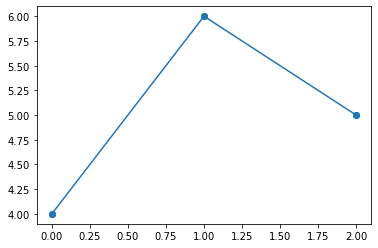

In [12]:
fit_hist = []
gen_hist = []
for i in range(20):
    s = Sudoku()
    s.load(board)
    solution = s.solve()
    fit_hist.append(solution[1])
    gen_hist.append(solution[0])
    
plt.scatter([i for i in range(len(gen_hist))],gen_hist)
plt.plot([i for i in range(len(gen_hist))],gen_hist, '-o')

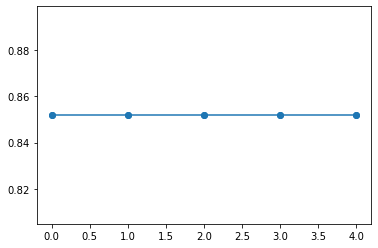

In [13]:
history = solution[1]
plt.scatter([i for i in range(len(history))],history)
plt.plot([i for i in range(len(history))],history, '-o')